In [1]:
!pip install vizdoom

In [2]:
!cd github & git clone https://github.com/Farama-Foundation/ViZDoom

In [1]:
# Import vizdoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# Import numpy for identity matrix
import numpy as np

In [2]:
# Setup game
game = DoomGame()
game.load_config('github/ViZDoom/scenarios/deadly_corridor_s1.cfg')
game.init()

In [3]:
# This is the set of actions we can take in the environment
actions = np.identity(7, dtype=np.uint8)

In [4]:
state = game.get_state()

In [5]:
state.game_variables

array([100.,   0.,   0.,  -1.])

# Loop through episodes
episodes = 10
for episode in range(episodes):
    # Create a new episode or game
    game.new_episode()
    # Check the game isn't done
    while not game.is_episode_finished():
        # Get the game state
        state = game.get_state()
        # Get the game image
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions), 4)
        # Print reward 
        # print('reward: ', reward)
        time.sleep(0.02)
    print('Result: ', game.get_total_reward())
    time.sleep(2)

In [6]:
game.close()

## 2. Converting it to a Gym Environment

In [7]:
!pip install gym

In [8]:
!pip install opencv-python

In [9]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces
from gym.spaces import Discrete, Box
# Import opencv
import cv2

In [10]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env):
    # Function that is called when we start the env
    def __init__(self, render=False, config='github/ViZDoom/scenarios/deadly_corridor_s1.cfg'):
        # Inherit from Env
        super().__init__()
        # Setup the game
        self.game = DoomGame()
        self.game.load_config(config)

        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # Start the game
        self.game.init()

        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)

        # Game variables: HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52 # initially I set it to 60 which didn't work out well...
    
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4) # 4 here is the frameskip parameter which makes the game run faster

        reward = 0

        # Get all the other stuff we need to return
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)

            # Reward shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables

            # Calculate reward deltas (delta -> change)
            damage_taken_delta = -damage_taken + self.damage_taken # negative reinforcing damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount # positively reinforcing hitcount
            self.hitcount = hitcount
            ammo_delta = -ammo + self.ammo # negatively reinforcing ammo
            self.ammo = ammo

            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200 + ammo_delta*5
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0

        info = {'info': info}
        done = self.game.is_episode_finished()

        return state, reward, done, info
        
    # Define how to render the game or environment
    def render():
        pass

    # What happens when we start a new game
    def reset(self):
        # It is considered best practice to reset variables, so trying this out as well! :3 
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52
        
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)

    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state

    # Call to close down the game
    def close(self):
        self.game.close()

In [11]:
env = VizDoomGym(render=True)

In [12]:
state = env.reset()

In [13]:
env.step(2)

(array([[[32],
         [33],
         [25],
         ...,
         [27],
         [23],
         [24]],
 
        [[27],
         [33],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        [[20],
         [35],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 0.0,
 False,
 {'info': 52.0})

In [14]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [15]:
# env_checker.check_env(env)

## 3. View State

In [16]:
from matplotlib import pyplot as plt

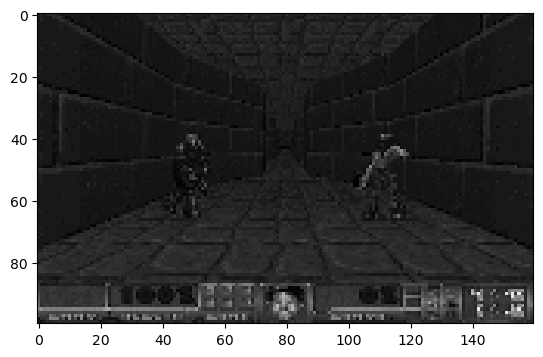

In [17]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [18]:
env.close()

## 4. Setup Callback

In [19]:
!pip install stable-baselines3[extra]

In [20]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [21]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [22]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [23]:
CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'

In [24]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## 5. Train Our Model Using Curriculum

In [25]:
# Import ppo for training 
from stable_baselines3 import PPO

In [26]:
# Non rendered environment
env = VizDoomGym(config='github/ViZDoom/scenarios/deadly_corridor_s1.cfg')

In [38]:
# model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [102]:
# model.learn(total_timesteps=40000, callback=callback)
model.learn(total_timesteps=400000, callback=callback)

Logging to ./logs/log_corridor\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 194      |
|    ep_rew_mean     | 88.2     |
| time/              |          |
|    fps             | 37       |
|    iterations      | 1        |
|    time_elapsed    | 219      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 185          |
|    ep_rew_mean          | 116          |
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 2            |
|    time_elapsed         | 835          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0035515353 |
|    clip_fraction        | 0.158        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_varian

In [ ]:
model.load('./train/train_corridor/best_model_260000.zip')

In [39]:
env = VizDoomGym(config='github/ViZDoom/scenarios/deadly_corridor_s2.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_3


KeyboardInterrupt: 

## 6. Test the Model

In [32]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [33]:
# Reload model from disk
model = PPO.load('./train/train_corridor/best_model_400000')

In [34]:
# Create rendered environment
env = VizDoomGym(render=True)

In [36]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

In [37]:
mean_reward

158.59920806884764

In [79]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward += reward

    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 11.0
Total Reward for episode 1 is 9.0
Total Reward for episode 2 is 8.0
Total Reward for episode 3 is 11.0
Total Reward for episode 4 is 8.0


In [65]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
print(f'Mean reward over 100 episodes: {mean_reward}')

Mean reward over 100 episodes: 12.8


In [72]:
episode_lengths = []
success_count = 0
rewards = []

# Define a success threshold (e.g., 10 as an example; adjust based on your environment)
success_threshold = 7

for episode in range(100):
    obs = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1

    episode_lengths.append(steps)
    rewards.append(total_reward)
    
    # Check if the episode is successful
    if total_reward > success_threshold:
        success_count += 1

avg_episode_length = np.mean(episode_lengths)
success_rate = success_count / 100
reward_variance = np.var(rewards)

print(f'Average Episode Length: {avg_episode_length}')
print(f'Success Rate: {success_rate}')
print(f'Reward Variance (Stability): {reward_variance}')

Average Episode Length: 177.44
Success Rate: 0.91
Reward Variance (Stability): 3.7619


### Import Necessary Libraries for Visualization

In [73]:
import matplotlib.pyplot as plt
import numpy as np

### Visualizations!

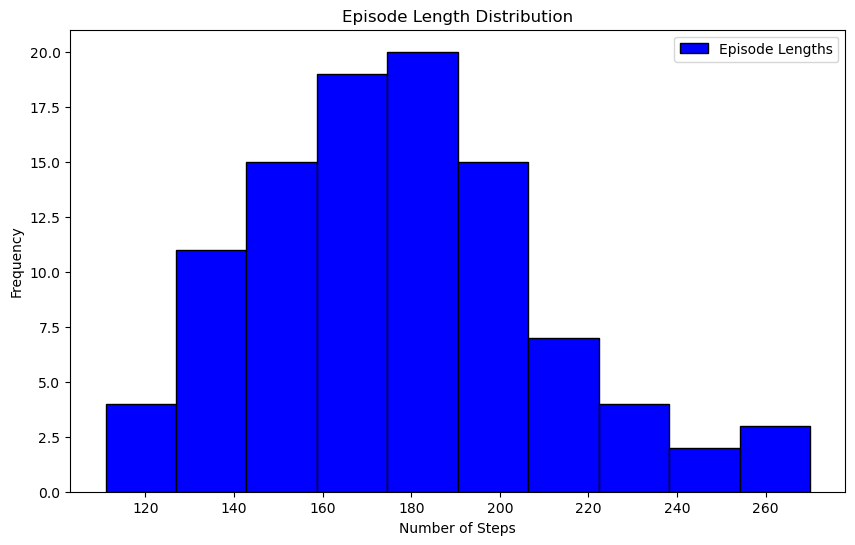

In [74]:
# Visualize Episode Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(episode_lengths, bins=10, color='blue', edgecolor='black', label='Episode Lengths')
plt.title('Episode Length Distribution')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.legend(loc='upper right')  # Add legend
plt.show()

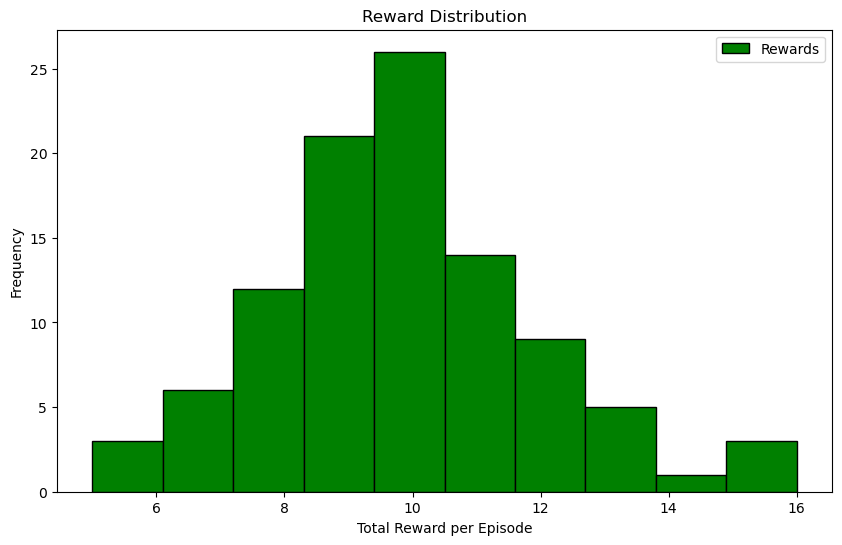

In [75]:
# Visualize Reward Distribution
plt.figure(figsize=(10, 6))
plt.hist(rewards, bins=10, color='green', edgecolor='black', label='Rewards')
plt.title('Reward Distribution')
plt.xlabel('Total Reward per Episode')
plt.ylabel('Frequency')
plt.legend(loc='upper right')  # Add legend
plt.show()

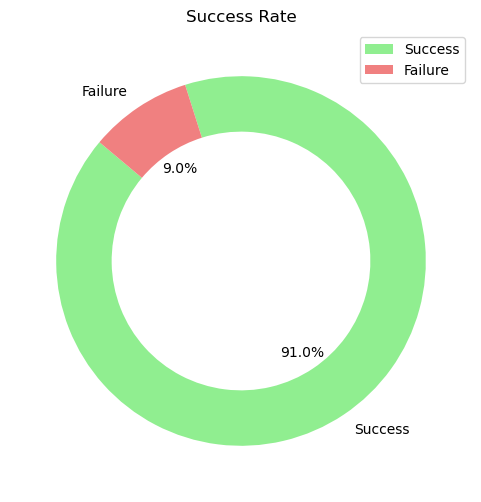

In [76]:
# Visualize Success Rate (Doughnut Chart)
plt.figure(figsize=(6, 6))
labels = ['Success', 'Failure']
sizes = [success_rate * 100, (1 - success_rate) * 100]
colors = ['lightgreen', 'lightcoral']

# Create a doughnut chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))

# Add a legend
plt.legend(labels, loc='best')

plt.title('Success Rate')
plt.show()

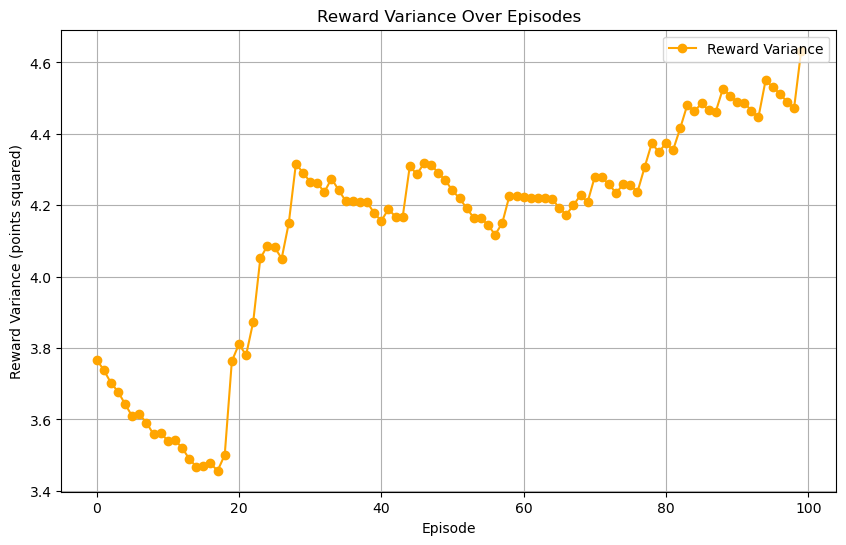

In [77]:
# Visualize Reward Variance Over Time (Line Chart)
reward_variances = []

for episode in range(100):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward

    rewards.append(total_reward)
    if len(rewards) > 1:
        variance = np.var(rewards)
        reward_variances.append(variance)

# Create a line chart for reward variance
plt.figure(figsize=(10, 6))
plt.plot(reward_variances, color='orange', marker='o', label='Reward Variance')
plt.title('Reward Variance Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward Variance (points squared)')
plt.grid(True)
plt.legend(loc='upper right')  # Add legend
plt.show()